## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import yfinance as yf

## Load and Preprocess Data

In [2]:
# Load Tesla stock data
tsla_data = pd.read_csv("../data/cleaned_tsla_data.csv", parse_dates=['Date'], index_col='Date')
tsla_data = tsla_data[['Adj Close']]  # Ensure we're only using the Adjusted Close price

In [22]:
tsla_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    1
Volume       0
dtype: int64

In [27]:
tsla_data.fillna(method='ffill', inplace=True)  # fill missing values
tsla_data = tsla_data.dropna(subset=['Adj Close'])

In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tsla_data["Adj Close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -9.908203309903513
p-value: 3.221043070336439e-17


In [33]:
# Check if initial p-value is greater than 0.05
if result[1] > 0.05:
    # Apply differencing to make the series stationary
    tsla_data["Adj Close"] = tsla_data["Adj Close"].diff().dropna()
    
    # Run the ADF test again
    result = adfuller(tsla_data["Adj Close"])
    
# Interpret stationarity
stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

# Print results
print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")


ADF Statistic after differencing: -9.908203309903513
p-value after differencing: 3.221043070336439e-17
Interpretation: The series is Stationary.


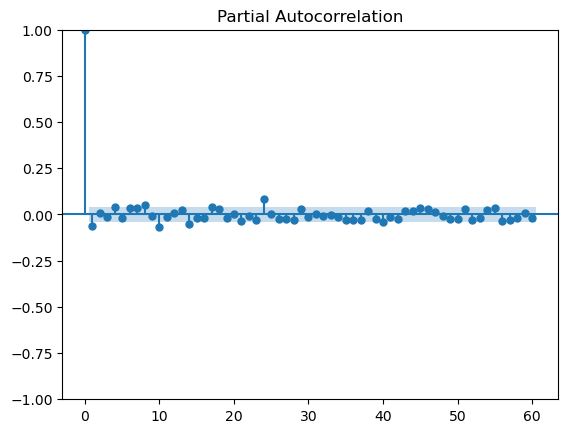

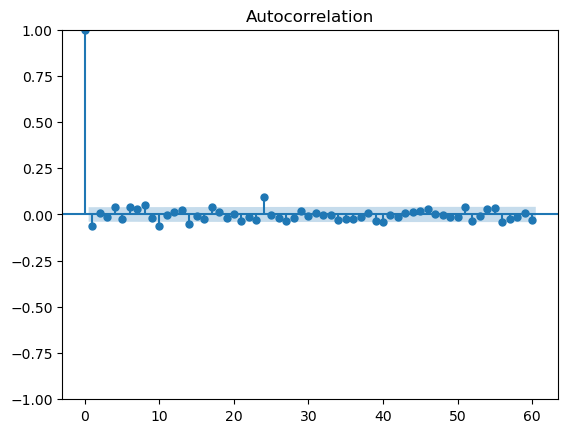

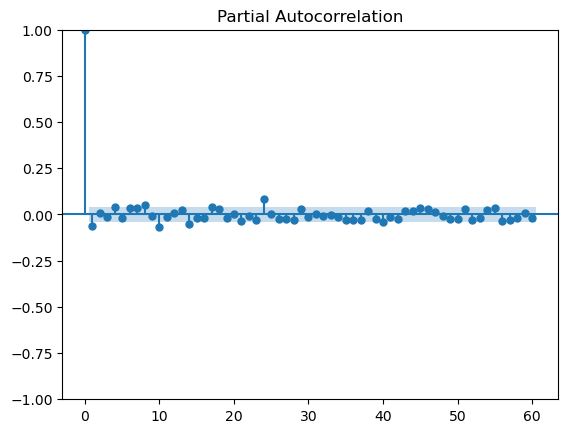

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tsla_data["Adj Close"], lags=60)
plot_pacf(tsla_data["Adj Close"], lags=60)

In [38]:
# Fit the ARIMA model
# Initial ARIMA Model parameters
p, d, q = 1, 0, 1
model = ARIMA(tsla_data["Adj Close"], order=(p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2473
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8015.755
Date:                Sun, 10 Nov 2024   AIC                          16039.510
Time:                        05:31:06   BIC                          16062.763
Sample:                             0   HQIC                         16047.956
                               - 2473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0982      0.124      0.792      0.428      -0.145       0.341
ar.L1         -0.7386      0.083     -8.906      0.000      -0.901      -0.576
ma.L1          0.6931      0.088      7.910      0.000       0.521       0.865
sigma2        38.2718      0.482     79.345      0.000      37.326      39.217
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):              8440.45
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):             431.14   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

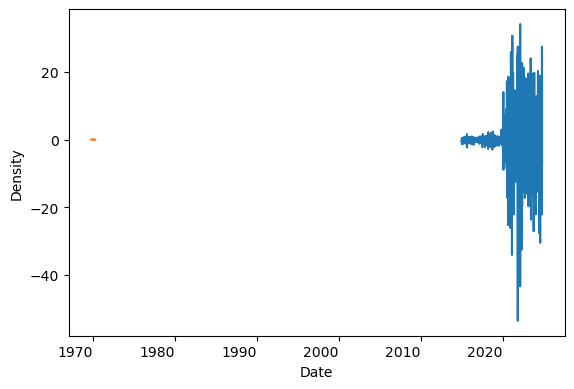

In [39]:
# plot residual errors
residuals = model_fit.resid
residuals.plot()
residuals.plot(kind='kde')
plt.show()

In [40]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 16039.509818612485
BIC: 16062.76256768257


In [41]:
# Load and split the data
data = tsla_data["Adj Close"]
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Define ARIMA parameters (p, d, q)
p, d, q = 5, 1, 0  # replace with optimal values if needed

# Fit the ARIMA model to training data
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecast for the test set length
forecast = model_fit.forecast(steps=len(test))

# Display the forecasted values
print(forecast)


c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1978   -6.799126
1979   -7.633424
1980   -5.458475
1981   -8.716259
1982   -7.893331
          ...   
2468   -7.229979
2469   -7.229979
2470   -7.229979
2471   -7.229979
2472   -7.229979
Name: predicted_mean, Length: 495, dtype: float64


c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


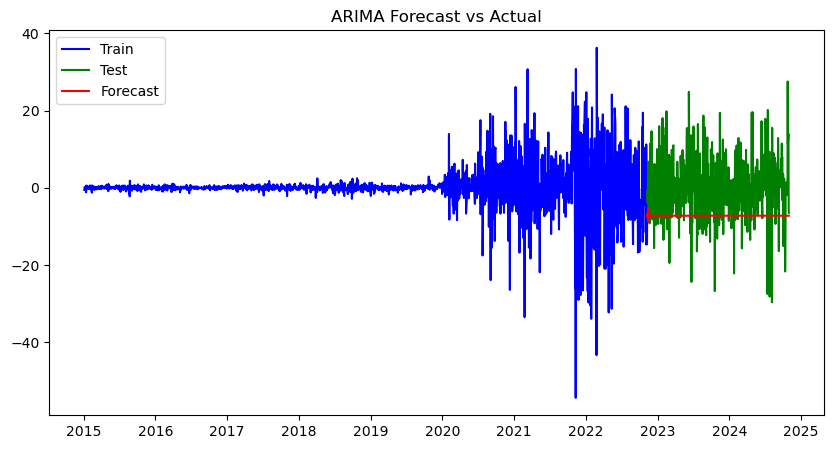

In [42]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data.index[:train_size], train, label='Train', color='blue')
plt.plot(data.index[train_size:], test, label='Test', color='green')
plt.plot(data.index[train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [44]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Evaluate model performance on the test set
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = mean_absolute_percentage_error(test, forecast)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Error (MAE): 8.674869969990263
Root Mean Squared Error (RMSE): 10.681651795492302
Mean Absolute Percentage Error (MAPE): 6577966196400088.00%


c:\Users\getac\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Train Test Split

In [3]:
# Splitting into train and test sets
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data[:train_size], tsla_data[train_size:]


## ARIMA Model

### ARIMA Model with Auto-Parameter Selection Using auto_arima

In [4]:
from pmdarima import auto_arima

# Use auto_arima to determine the best (p, d, q) parameters
auto_arima_model = auto_arima(train, seasonal=False, trace=True)
p, d, q = auto_arima_model.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12538.583, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12538.774, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12533.730, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12533.682, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12537.246, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12535.663, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12535.670, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12537.674, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12532.220, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12534.210, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12534.212, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12532.264, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12536.215, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.523 seconds


### model Training

In [5]:
# Fit ARIMA Model
arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test))

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

### Evaluation Metrics for ARIMA

In [6]:
# Evaluation
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print(f"ARIMA Model - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

ARIMA Model - MAE: 33.8911422737386, RMSE: 42.0921542756094, MAPE: nan


Notes:
- Parameter Tuning with Auto ARIMA: Using auto_arima is excellent for automatically selecting (p, d, q). Make sure it selects sensible values by inspecting trace=True.

- Metrics: MAE, RMSE, and MAPE are standard metrics, and you’ve correctly applied them.

## SARIMA Model 

### SARIMA Model Training

In [7]:
# SARIMA model with seasonal components
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_model_fit.forecast(steps=len(test))


c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

## LSTM Model with Hyperparameter Tuning Using GridSearchCV

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare data for LSTM
sequence_length = 60  # Example sequence length
generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=32)

# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(generator, epochs=20, verbose=1)


Epoch 1/20
60/60 [==============================] - 6s 50ms/step - loss: 0.0309
Epoch 2/20
60/60 [==============================] - 3s 49ms/step - loss: 0.0066
Epoch 3/20
60/60 [==============================] - 3s 50ms/step - loss: 0.0049
Epoch 4/20
60/60 [==============================] - 3s 51ms/step - loss: 0.0036
Epoch 5/20
60/60 [==============================] - 3s 52ms/step - loss: 0.0037
Epoch 6/20
60/60 [==============================] - 3s 51ms/step - loss: 0.0039
Epoch 7/20
60/60 [==============================] - 3s 52ms/step - loss: 0.0035
Epoch 8/20
60/60 [==============================] - 3s 52ms/step - loss: 0.0033
Epoch 9/20
60/60 [==============================] - 3s 51ms/step - loss: 0.0033
Epoch 10/20
60/60 [==============================] - 3s 52ms/step - loss: 0.0031
Epoch 11/20
60/60 [==============================] - 3s 52ms/step - loss: 0.0034
Epoch 12/20
60/60 [==============================] - 3s 52ms/step - loss: 0.0027
Epoch 13/20
60/60 [==================

In [9]:
# Predicting on test data
test_sequences = []
for i in range(sequence_length, len(test_scaled)):
    test_sequences.append(test_scaled[i-sequence_length:i, 0])
test_sequences = np.array(test_sequences)
test_sequences = np.reshape(test_sequences, (test_sequences.shape[0], test_sequences.shape[1], 1))

lstm_forecast = lstm_model.predict(test_sequences)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Invert scaling


14/14 [==============================] - 1s 15ms/step


In [10]:
mae = mean_absolute_error(test[sequence_length:], lstm_forecast)
rmse = np.sqrt(mean_squared_error(test[sequence_length:], lstm_forecast))
mape = np.mean(np.abs((test[sequence_length:] - lstm_forecast) / test[sequence_length:])) * 100

print(f"LSTM Model - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")


LSTM Model - MAE: 17.333204668417743, RMSE: 20.838720042099705, MAPE: 8.562754763557361


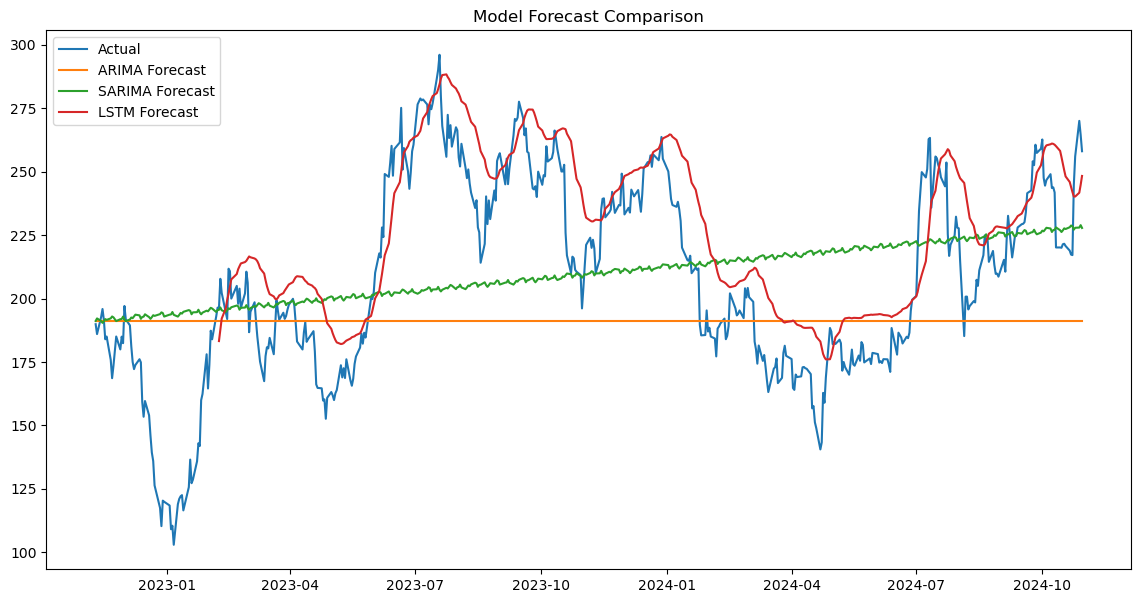

In [11]:
plt.figure(figsize=(14,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(test.index[sequence_length:], lstm_forecast, label='LSTM Forecast')
plt.legend()
plt.title('Model Forecast Comparison')
plt.show()


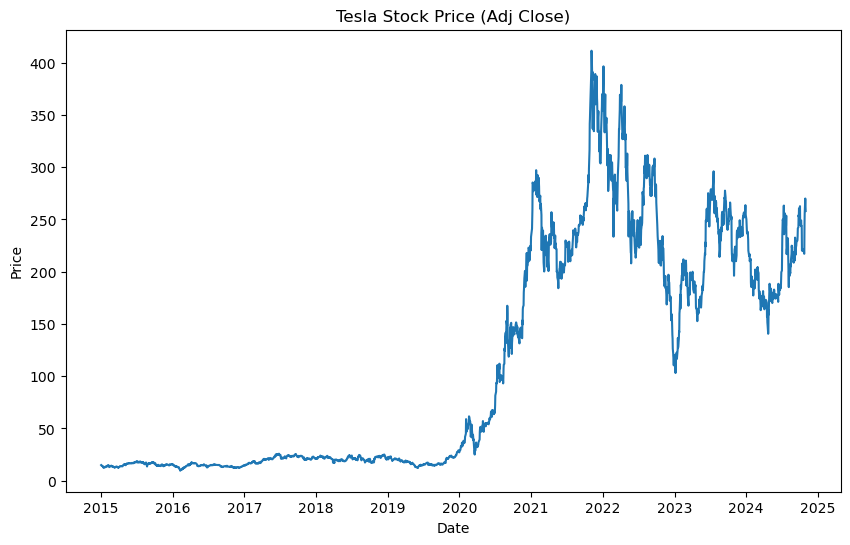

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

# Load the data
tsla_data = pd.read_csv("../data/cleaned_tsla_data.csv", parse_dates=['Date'], index_col='Date')

# Visualize the adjusted close price
plt.figure(figsize=(10,6))
plt.plot(tsla_data['Adj Close'])
plt.title('Tesla Stock Price (Adj Close)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


ADF Statistic: -1.2077635687688493
p-value: 0.670247135774911


c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

MAE: 8.674869957671936
RMSE: 10.681651783805956
MAPE: nan


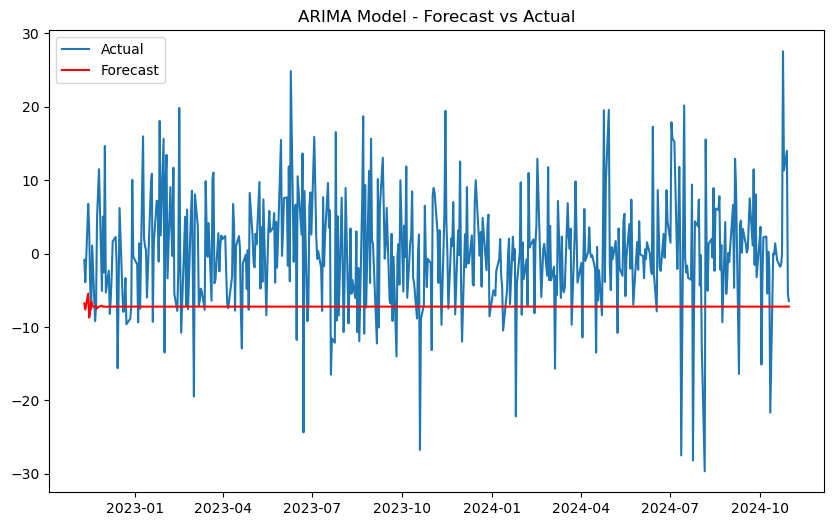

In [13]:
# 1. Check for stationarity (ADF Test)
adf_test = adfuller(tsla_data['Adj Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, we need to difference the data
if adf_test[1] > 0.05:
    tsla_data['Adj Close'] = tsla_data['Adj Close'].diff().dropna()

# 2. Split data into train and test sets
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data[:train_size], tsla_data[train_size:]

# 3. Build ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(train['Adj Close'], order=(5,1,0))  # p=5, d=1, q=0 (to be optimized later)
model_fit = model.fit()

# 4. Forecast future values
forecast = model_fit.forecast(steps=len(test))

# 5. Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['Adj Close'], forecast)
rmse = np.sqrt(mean_squared_error(test['Adj Close'], forecast))
mape = np.mean(np.abs((test['Adj Close'] - forecast) / test['Adj Close'])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot the forecast vs actual values
plt.figure(figsize=(10,6))
plt.plot(test.index, test['Adj Close'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - Forecast vs Actual')
plt.show()


In [14]:
# Check for missing values in the 'Adj Close' column
print(train['Adj Close'].isnull().sum())


1


In [15]:
train = train.dropna(subset=['Adj Close'])


In [16]:
from pmdarima import auto_arima

# Auto ARIMA for optimal p, d, q
auto_model = auto_arima(train['Adj Close'], seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())

# Fit the model with optimal parameters
model = ARIMA(train['Adj Close'], order=auto_model.order)
model_fit = model.fit()

# Forecast with optimized model
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mae = mean_absolute_error(test['Adj Close'], forecast)
rmse = np.sqrt(mean_squared_error(test['Adj Close'], forecast))
mape = np.mean(np.abs((test['Adj Close'] - forecast) / test['Adj Close'])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12537.134, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12537.246, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12532.264, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12532.220, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12534.210, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12534.212, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12536.215, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12533.682, Time=0.17 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.236 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1978
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -6264.110
Date:                Sun, 10 Nov 2024   AIC                          12532.220
Time:                       

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\getac\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

MAE: 9.352675545578752
RMSE: 11.293097541301458
MAPE: nan


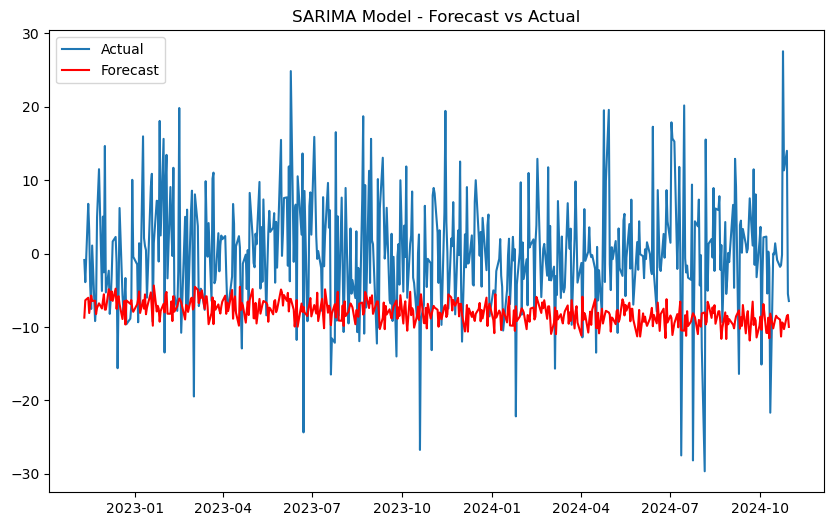

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
sarima_model = SARIMAX(train['Adj Close'], order=(5,1,0), seasonal_order=(1,1,1,60))  # p=5, d=1, q=0, s=252 for yearly seasonality
sarima_fit = sarima_model.fit()

# Forecast
forecast = sarima_fit.forecast(steps=len(test))

# Evaluate
mae = mean_absolute_error(test['Adj Close'], forecast)
rmse = np.sqrt(mean_squared_error(test['Adj Close'], forecast))
mape = np.mean(np.abs((test['Adj Close'] - forecast) / test['Adj Close'])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot the forecast vs actual values
plt.figure(figsize=(10,6))
plt.plot(test.index, test['Adj Close'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('SARIMA Model - Forecast vs Actual')
plt.show()
